In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import gym

### Download Tile Coding software

In [ ]:
!mkdir -p ../external && wget --output-document="../external/tiles3.py" http://incompleteideas.net/tiles/tiles3.py-remove

### Setup the learning model

In [2]:
sys.path.append('../external')
from tiles3 import tiles, IHT

class TileCodingModel:
    def __init__(self, weights, numTilings=8, alpha=0.1, scaleFactorX=10, scaleFactorY=10):
        self.weights = weights
        self.iht = IHT(len(self.weights))
        self.numTilings = numTilings
        self.stepSize = alpha/self.numTilings
        self.scaleFactorX = scaleFactorX
        self.scaleFactorY = scaleFactorY

    def mytiles(self, x, y):
        return tiles(self.iht, self.numTilings, [x*self.scaleFactorX,y*self.scaleFactorY])

    def learn(self, x, y, z):
        tiles = self.mytiles(x, y)
        estimate = 0
        for tile in tiles:
            estimate += self.weights[tile]                  #form estimate
        error = z - estimate
        for tile in tiles:
            self.weights[tile] += self.stepSize * error     #learn weights

    def test(self, x, y):
        tiles = self.mytiles(x, y)
        estimate = 0
        for tile in tiles:
            estimate += self.weights[tile]
        return estimate

In [27]:
sys.path.append('..')
import SeqGen
import SARSAn

actions_dim = 3

class getActionValues:
    def __init__(self, models):
        self.models = models

    def __getitem__(self, state):
        return [m.test(state[0],state[1]) for m in models]

w = (np.random.rand(actions_dim, 4096) - 0.5) * 0.001
models = [TileCodingModel(w[i],numTilings=16,scaleFactorX=10,scaleFactorY=20,alpha=0.01) 
          for i in range(actions_dim)]

# Need for SeqGen.EpsilonGreedyPolicy
q_s_a_func = getActionValues(models)

### Problem environment setup

In [28]:
import MountainCarSetup as mc

def getStateTransition(s,a):
    p,v,f,r = mc.getTransition(s[0], s[1], a-1.0)
    return (f, (p,v), r)

In [34]:
sequence = SeqGen.SequenceGeneratorPlus(SeqGen.EpsilonGreedyPolicy(q_s_a_func, 0.1), 
                                  mc.getStartPosition,
                                  getStateTransition,
                                  episodes_max=0,
                                  steps_max=200000
                                 )

### Run learning

In [35]:
SARSAn.SARSAn(sequence,
       lambda s,a: models[a].test(s[0],s[1]),
       lambda s,a,t: models[a].learn(s[0],s[1],t),
       n=4,
       gamma=0.99
      )

Episode length is     149
Sequence terminated.

Finished.


### Evaluate the performance
#### Computes mean of episode lengths, thuncated to 1000 steps

In [36]:
sequence = SeqGen.SequenceGeneratorPlus(
                                  lambda s: np.argmax(q_s_a_func[s]),
                                  mc.getStartPosition,
                                  getStateTransition,
                                  100,
                                  episode_maxlen=999
                                 )

In [49]:
it = iter(sequence)
#next(it)
np.mean([sequence.episode_step for state, is_terminal, next_state, action, reward in it if is_terminal])
#[sequence.episode_step for state, is_terminal, next_state, action, reward in it if next_state==None]

140.57

### Draw the value function

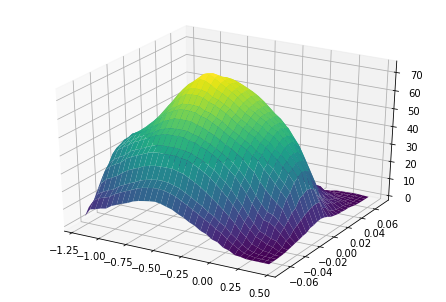

In [38]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

X = np.arange(-1.2, 0.5, 0.05)
Y = np.arange(-0.07, 0.07, 0.005)
X, Y = np.meshgrid(X, Y)

it = zip(X.ravel(), Y.ravel())

Z = np.array([-np.max(q_s_a_func[s]) for s in it]).reshape(X.shape)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.viridis)

plt.show()

In [25]:
q_s_a_func[(0.1,0.01)]

[0.0005252633331242504, -0.00018477946663500482, -0.00043087421037948134]

In [91]:
models[0].learn(0.1,0.01, 0.1)
models[0].test(0.1,0.01)

0.09975479132184958

### Problem environment setup with use of 'gym' library

#### Reset the learning model, if required

In [39]:
w = (np.random.rand(actions_dim, 4096) - 0.5) * 0.001
models = [TileCodingModel(w[i],numTilings=16,scaleFactorX=10,scaleFactorY=20,alpha=0.01) 
          for i in range(actions_dim)]

#### Setup problem environment without visualisation

In [47]:
env_name = 'MountainCar-v0'
env = gym.make(env_name)

def getStateTransition(s,a):
    #env.render()
    next_state, reward, done, info = env.step(a)
    return (done, tuple(next_state), reward)

In [44]:
sequence = SeqGen.SequenceGeneratorPlus(
                            SeqGen.EpsilonGreedyPolicy(q_s_a_func, 0.1), 
                            lambda: tuple(env.reset()),
                            getStateTransition,
                            episodes_max=0,
                            steps_max=200000
                           )

In [45]:
SARSAn.SARSAn(sequence,
       lambda s,a: models[a].test(s[0],s[1]),
       lambda s,a,t: models[a].learn(s[0],s[1],t),
       n=4,
       gamma=0.99
      )
env.close()

Episode length is     148
Sequence terminated.

Finished.


### Visualized test runs with use of 'gym' library

In [ ]:
env_name = 'MountainCar-v0'
env = gym.make(env_name)

def getStateTransition(s,a):
    env.render()
    next_state, reward, done, info = env.step(a)
    return (done, tuple(next_state), reward)

In [48]:
sequence = SeqGen.SequenceGeneratorPlus(
                                  lambda s: np.argmax(q_s_a_func[s]),
                                  lambda: tuple(env.reset()),
                                  getStateTransition,
                                  100,
                                 )

In [ ]:
it = iter(sequence)
length = []
for step in it:
    state, is_terminal, next_state, action, reward = step
    if is_terminal:
        print("Episode: {:5}, steps: {:3}".format(sequence.episode_i-1, sequence.episode_step))
        length.append(sequence.episode_step)

print(np.mean(length))
env.close()

In [75]:
np.mean(length)

131.05